In [7]:
%reset

In [3]:
import time
import copy
import gzip
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import torch

from io import BytesIO
from time import sleep 
from tqdm import tqdm

from config import PATH_TO_FEATURES

PATH_TO_LINKING_DATA = '../../datasets/string/'
PATH_TO_SAVE_DATA_TO = '../../datasets/string/my_datasets/'

PROTEIN_LINKS_FILE = '9606.protein.links.detailed.v11.5.txt.gz'
PROTEIN_INFO_FILE = '9606.protein.info.v11.5.txt.gz'

sns.set_theme(style="white")

print("pytorch version:", torch.__version__)
print("is cuda available:", torch.cuda.is_available())

pytorch version: 1.11.0
is cuda available: False


# Build a Sparse Graph with as much landmark genes as possible

We already created two datasets with graphs per cell-line. 
- In [`07_v1_get_linking_dataset.ipynb`](07_v1_get_linking_dataset.ipynb) we created a dataset with gene-gene interactions graphs per cell-line of topology `Data(x=[858, 4], edge_index=[2, 83126])`. They have been saved in `../../datasets/datasets_for_model_building/cl_graphs_as_dict.pkl`.
  - __Problem__: The number of edges 83,126 was way to high to even run a single epoch locally.
- In [`07_v2_graph_dataset.ipynb`](07_v2_graph_dataset.ipynb) we created a dataset with gene-gene interactions graphs per cell-line of topology `Data(x=[458, 4], edge_index=[2, 4760])`. They have been saved in `../../datasets/datasets_for_model_building/cl_graphs_as_dict_SPARSE.pkl`. We selected first only the protein tuples with a combined score higher then 950 and then selected only the landmark genes.
  - __Problem__: Even though we lowered the number of edges significantly, now we lost nearly half of all the genes, which may provide valuable information.

_Objective_: The objective of this notebook is to lower the number of edges down from 83,126 __while maintaining as much genes as possible__.

_Approach_: We 1st select only landmark genes out of the protein database and then 2nd use the `combined_score` column in the protein-interaction dataset.

_TODOs_: 
- [ ] select only the protein-protein tuples where both proteins are landmark genes
- [ ] after the first step, tune the `combined_score` column threshold in such a way that as close to 858 genes as possible stay in the dataset

### Helper Methods

In [6]:
def read_protein_links(path: str):
    print(f"Start reading `{path}`...")
    contents = gzip.open(path, "rb").read()
    data = BytesIO(contents)
    protein_links_v1 = pd.read_csv(data, sep=' ')
    print("Finished reading.")

    # Exclude the Homo Sapiens taxonomy ID from the protein columns.
    protein_links_v2 = protein_links_v1.copy()
    protein_links_v2.protein1 = protein_links_v2.protein1.str[5:]
    protein_links_v2.protein2 = protein_links_v2.protein2.str[5:]

    return protein_links_v2

def read_protein_info(path: str):
    contents = gzip.open(path, "rb").read()
    data = BytesIO(contents)
    protein_info_v1 = pd.read_csv(data, sep='\t')
    protein_info_v2 = protein_info_v1.rename(columns={'#string_protein_id': 'string_protein_id'}, inplace=False)

    # Exclude the Homo Sapiens taxonomy ID from the protein columns.
    protein_info_v2.string_protein_id = protein_info_v2.string_protein_id.str[5:]

    return protein_info_v2

def combine_protein_links_with_info(links: pd.DataFrame, infos: pd.DataFrame):
    """
    Maps the corresponding gene symbols to the proteins in the protein link dataset.

    Args:
        links (pd.DataFrame): DataFrame containing at least the columns `protein1` and `protein2`.
        infos (pd.DataFrame): DataFrame containing at least the columns `string_protein_id` and `preferred_name`.
    Returns:
        (pd.DataFrame): DataFrame containing the corresponding `gene_symbol` per `protein1` and `protein2`.
    """
    # Get the gene symbols for the protein1 column.
    res = links.merge(right    = infos[['string_protein_id', 'preferred_name']],
                      how      = 'left',
                      left_on  = 'protein1',
                      right_on = 'string_protein_id')
    res.rename(columns={'preferred_name': 'gene_symbol1'}, inplace=True)
    res.drop(['string_protein_id'], axis=1, inplace=True)

    # Get the gene symbols for the protein2 column.
    res = res.merge(right    = infos[['string_protein_id', 'preferred_name']],
                    how      = 'left',
                    left_on  = 'protein2',
                    right_on = 'string_protein_id')
    res.rename(columns={'preferred_name': 'gene_symbol2'}, inplace=True)
    res.drop(['string_protein_id'], axis=1, inplace=True)

    # Drop all rows where the gene symbol has not been found.
    res.dropna(subset=['gene_symbol1', 'gene_symbol2'], inplace=True)

    assert not res[['gene_symbol1', 'gene_symbol2']].isna().sum().any(),\
        "Some gene_symbol columns are missing!"

    return res    

## Create protein dataset
In this section we will create the full base protein dataset which then will be used for further model-specific selection.
### Load protein link dataset
In this subsection we will load the protein linking dataset which contains for a given protein-protein tuple information about their certainty of connection.

In [7]:
protein_links = read_protein_links(f'{PATH_TO_LINKING_DATA}{PROTEIN_LINKS_FILE}')
print(protein_links.shape)
protein_links.head(3)

Start reading `../../datasets/string/9606.protein.links.detailed.v11.5.txt.gz`...
Finished reading.
(11938498, 10)


,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
0,ENSP00000000233,ENSP00000379496,0,0,0,54,0,0,144,155
1,ENSP00000000233,ENSP00000314067,0,0,0,0,180,0,61,197
2,ENSP00000000233,ENSP00000263116,0,0,0,62,152,0,101,222


- there are 11,938,498 protein-protein connections in the given dataset
- each connection row contains a `combined_score` value

      coexpression textmining experimental combined_score
count     11938498   11938498     11938498       11938498
mean            62        180           69            280
std             97        153          120            167
min              0          0            0            150
25%              0         67            0            175
50%             54        161            0            216
75%             76        241          129            309
max            999        997          999            999


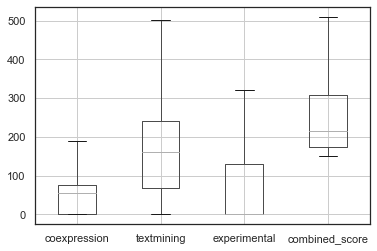

In [9]:
print(protein_links[['coexpression', 'textmining', 'experimental', 'combined_score']].describe().apply(lambda s: s.apply('{0:.0f}'.format)))
protein_links[['coexpression', 'textmining', 'experimental', 'combined_score']].boxplot(showfliers=False);

- the `combined_score` column seems to lie in $[150, 999]$

## Load protein info dataset

In this subsection we will load the protein information dataset which contains the gene symbol for each protein ID. This will be used to obtain the corresponding gene symbols for each protein `protein1` and `protein2` respectively in the protein link dataset from the previous subsection.

In [10]:
protein_infos_v0 = read_protein_info(f'{PATH_TO_LINKING_DATA}{PROTEIN_INFO_FILE}')
print(protein_infos_v0.shape)
print(f"There are {len(protein_infos_v0.preferred_name.unique())} unique gene symbols in `preferred_name`.")
protein_infos_v0.head(3)

(19566, 4)
There are 19563 unique gene symbols in `preferred_name`.


,string_protein_id,preferred_name,protein_size,annotation
0,ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,ENSP00000001008,FKBP4,459,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...


- this dataset gives us the gene symbol for each protein ID.
- some `preferred_name` (gene symbols) occur more then one time

In [11]:
freq_per_gene = protein_infos_v0.groupby(['preferred_name']).size().reset_index(name='freq', inplace=False).sort_values(['freq'], ascending=False)
print(freq_per_gene[freq_per_gene.freq>1])

# Remove the gene symbols which have a frequency higher than 1.
protein_infos = protein_infos_v0[~protein_infos_v0.preferred_name.isin(freq_per_gene[freq_per_gene.freq>1].preferred_name.tolist())]
print(protein_infos.shape)
protein_infos.head(3)

       preferred_name  freq
5100  ENSG00000205457     2
5106  ENSG00000229117     2
5243  ENSG00000268221     2
(19560, 4)


,string_protein_id,preferred_name,protein_size,annotation
0,ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,ENSP00000001008,FKBP4,459,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...


### Combine protein link and info

In this subsection we will add the `preferred_name`'s to the protein columns of the link dataset. This way we obtain the corresponding gene symbols for each protein of each tuple.

In [12]:
proteins = combine_protein_links_with_info(protein_links, protein_infos)
print(proteins.shape)
proteins.head(3)

(11936122, 12)


,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene_symbol1,gene_symbol2
0,ENSP00000000233,ENSP00000379496,0,0,0,54,0,0,144,155,ARF5,PDE1C
1,ENSP00000000233,ENSP00000314067,0,0,0,0,180,0,61,197,ARF5,PAK2
2,ENSP00000000233,ENSP00000263116,0,0,0,62,152,0,101,222,ARF5,RAB36


In [13]:
print(f"""Shapes
    before joining : {protein_links.shape}
    after  joining : {proteins.shape}
There are 
    {len(proteins.gene_symbol1.unique())} unique genes (gene_symbol1) per column
    {len(proteins.gene_symbol2.unique())} unique genes (gene_symbol2) per column    
""")
# Unique number of gene-gene combinations.
freq_per_tuple = proteins\
    .groupby(['gene_symbol1', 'gene_symbol2']).size()\
    .reset_index(name='freq', inplace=False)\
    .sort_values(['freq'], ascending=False)
freq_per_tuple.groupby(['freq']).size().reset_index(name='count', inplace=False)

Shapes
    before joining : (11938498, 10)
    after  joining : (11936122, 12)
There are 
    19379 unique genes (gene_symbol1) per column
    19379 unique genes (gene_symbol2) per column    



,freq,count
0,1,11936122


## Select only landmark genes

In this subsection we will select only the gene-gene tuples `(gene_i, gene_j)` where both `gene_i` and `gene_j` are landmark genes.

In [15]:
with open(f'{PATH_TO_FEATURES}intersecting_genes.pkl', 'rb') as f: LANDMARK_GENES = list(pd.read_pickle(f))
print("Number of landmark genes:", len(LANDMARK_GENES))
# Assign unique index to each of the genes.
LM_GENES_IDXS = pd.DataFrame({'GENE_SYMBOL': list(LANDMARK_GENES)})
LM_GENES_IDXS['GENE_INDEX'] = LM_GENES_IDXS.index
LM_GENES_IDXS.head(5)

Number of landmark genes: 858


,GENE_SYMBOL,GENE_INDEX
0,ILK,0
1,MPC2,1
2,DAXX,2
3,NT5DC2,3
4,TSKU,4


In [16]:
# How many of the intersecting genes are also in the protein-protein interaction dataset?
print(len(list(set(proteins.gene_symbol1.unique()).intersection(set(LM_GENES_IDXS.GENE_SYMBOL.unique())))))
print(len(list(set(proteins.gene_symbol2.unique()).intersection(set(LM_GENES_IDXS.GENE_SYMBOL.unique())))))

858
858


In [28]:
# Select only the rows where both gene symbols are landmark genes
proteins_lm = proteins[(proteins.gene_symbol1.isin(LM_GENES_IDXS.GENE_SYMBOL)) &
                       (proteins.gene_symbol2.isin(LM_GENES_IDXS.GENE_SYMBOL))]
print(f"{proteins_lm.shape}, thus {100-100*proteins_lm.shape[0]/proteins.shape[0]:2.2f} % got removed")
uniq_g1, uniq_g2 = len(proteins_lm.gene_symbol1.unique()), len(proteins_lm.gene_symbol2.unique())
print(f"Number of unique gene_symbol1's: {uniq_g1} ({100-100*uniq_g1/len(proteins.gene_symbol1.unique()):2.2f} % got removed)")
print(f"Number of unique gene_symbol2's: {uniq_g2} ({100-100*uniq_g2/len(proteins.gene_symbol2.unique()):2.2f} % got removed)")
proteins_lm.head(3)

(83126, 12), thus 99.30 % got removed
Number of unique gene_symbol1's: 858 (95.57 % got removed)
Number of unique gene_symbol2's: 858 (95.57 % got removed)


,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene_symbol1,gene_symbol2
1940,ENSP00000001008,ENSP00000408295,0,0,0,81,0,0,258,288,FKBP4,RFC5
1953,ENSP00000001008,ENSP00000306245,0,0,0,0,59,0,177,192,FKBP4,FOS
1978,ENSP00000001008,ENSP00000340989,0,0,0,0,78,0,123,157,FKBP4,SFN


## Tune `combined_score` threshold

In this subsection we are going to tune the `combined_score` column such that as many gene symbols as possible stay in the resulting dataset.

In [39]:
threshs = np.arange(0.1, 1.0, 0.05)
rows = np.repeat(None, len(threshs))
uniq_g1s, uniq_g2s = np.repeat(None, len(threshs)), np.repeat(None, len(threshs))
for i, thresh in enumerate(threshs): 
    # print(f"thresh: {thresh*1_000:3.0f}\n{20*'='}")
    protein_temp = proteins_lm[proteins_lm['combined_score'] > (thresh * 1_000)]
    rows[i] = protein_temp.shape[0]
    uniq_g1s[i] = len(protein_temp.gene_symbol1.unique())
    uniq_g2s[i] = len(protein_temp.gene_symbol2.unique())

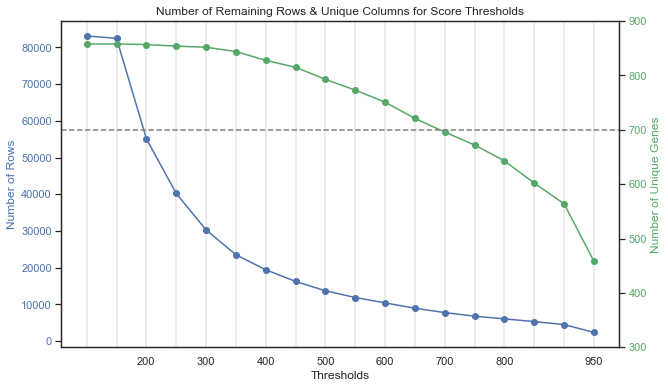

In [87]:
from matplotlib.pyplot import figure


fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(threshs*1_000, rows, 'bo-');
ax1.set_xlabel("Thresholds");
ax1.set_ylabel("Number of Rows", color='b');
ax1.tick_params(axis ='y', labelcolor = 'b')

ax2 = ax1.twinx()
ax2.plot(threshs*1_000, uniq_g1s, 'go-');
ax2.axhline(y=700, color='grey', linestyle='--');
ax2.set_ylabel("Number of Unique Genes", color='g');
ax2.tick_params(axis ='y', labelcolor = 'g');
ax2.set_ylim(300, 900);

for thresh in threshs:
    ax1.axvline(x=thresh*1_000, color='grey', linestyle='-', alpha=0.2);

plt.xticks([200, 300, 400, 500, 600, 700, 800, 950]);
plt.title("Number of Remaining Rows & Unique Columns for Score Thresholds");
plt.show();


[Zhu et. al., 2022](https://academic.oup.com/bioinformatics/article/38/2/461/6374919) also only worked with GDSC2 and ended up with 706 genes. Thus, an orientation number for the unique number of genes we want to have after choosing a threshold could be 700.

In [ ]:
SCORE_THRESH = 700